In [1]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/train/
   creating: data/train/knightley/
 extracting: data/train/knightley/1.png  
 extracting: data/train/knightley/100.png  
 extracting: data/train/knightley/11.png  
 extracting: data/train/knightley/12.png  
 extracting: data/train/knightley/13.png  
 extracting: data/train/knightley/14.png  
 extracting: data/train/knightley/15.png  
 extracting: data/train/knightley/16.png  
 extracting: data/train/knightley/17.png  
 extracting: data/train/knightley/18.png  
 extracting: data/train/knightley/2.png  
 extracting: data/train/knightley/20.png  
 extracting: data/train/knightley/21.png  
 extracting: data/train/knightley/24.png  
 extracting: data/train/knightley/25.png  
 extracting: data/train/knightley/26.png  
 extracting: data/train/knightley/27.png  
 extracting: data/train/knightley/28.png  
 extracting: data/train/knightley/31.png  
 extracting: data/train/knightley/32.png  
 extracting: data/train/knightley/

In [2]:
import os
import shutil
import re

base_dir = "/content/data/"

files = os.listdir(base_dir)

def train_maker(name):
  train_dir = f"{base_dir}/train/{name}"
  for f in files:
        search_object = re.search(name, f)
        if search_object:
          shutil.move(f'{base_dir}/{name}', train_dir)

train_maker("knightley")
train_maker("portman")

In [3]:
knightley_train = base_dir + "train/knightley/"
knightley_val = base_dir + "val/knightley/"
portman_train = base_dir + "train/portman/"
portman_val = base_dir + "val/portman/"

knightley_files = os.listdir(knightley_train)
portman_files = os.listdir(portman_train)

In [4]:
for f in knightley_files:
    validation_knightley_SearchObj = re.search("5\d\d\d", f)
    if validation_knightley_SearchObj:
        shutil.move(f'{knightley_train}/{f}', knightley_val)

for f in portman_files:
    validation_knightley_SearchObj = re.search("5\d\d\d", f)
    if validation_knightley_SearchObj:
        shutil.move(f'{portman_train}/{f}', portman_val)

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [6]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomRotation(degrees=5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [7]:
data_dir = '/content/data/'

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['train', 'val']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [9]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

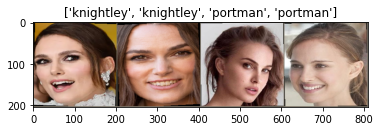

In [11]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
res_mod = models.googlenet(pretrained=True) # resnet152 and resnext101_32x8d also work fine
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [13]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(res_mod.parameters(), lr=3e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.05)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()  

            current_loss = 0.0
            current_corrects = 0

            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()
    acc = 0
    c = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5150 Acc: 0.7600
Iterating through data...
val Loss: 0.2942 Acc: 0.8800

Epoch 1/9
----------
Iterating through data...
train Loss: 0.3001 Acc: 0.8667
Iterating through data...
val Loss: 0.2334 Acc: 0.9200

Epoch 2/9
----------
Iterating through data...
train Loss: 0.2773 Acc: 0.8733
Iterating through data...
val Loss: 0.2469 Acc: 0.9000

Epoch 3/9
----------
Iterating through data...
train Loss: 0.2435 Acc: 0.9067
Iterating through data...
val Loss: 0.2281 Acc: 0.9200

Epoch 4/9
----------
Iterating through data...
train Loss: 0.2157 Acc: 0.9333
Iterating through data...
val Loss: 0.1723 Acc: 0.9600

Epoch 5/9
----------
Iterating through data...
train Loss: 0.1993 Acc: 0.9133
Iterating through data...
val Loss: 0.1941 Acc: 0.9400

Epoch 6/9
----------
Iterating through data...
train Loss: 0.2349 Acc: 0.9067
Iterating through data...
val Loss: 0.1706 Acc: 0.9600

Epoch 7/9
----------
Iterating through data...
train Loss: 0.1637 Acc: 0.9267
Iterating through data...
val L

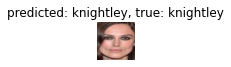

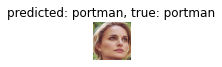

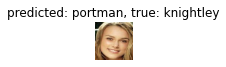

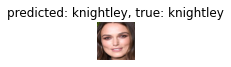

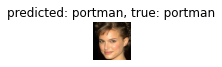

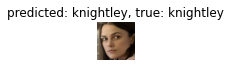

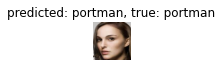

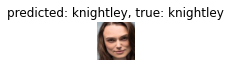

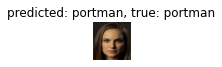

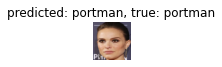

In [16]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(base_model)
plt.show()